In [5]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import glob
from tqdm import tqdm
import pandas as pd

import umap.umap_ as umap
import hdbscan

In [2]:
# Get file paths for images
images = glob.glob('images' + '/**/*.png', recursive=True)

In [3]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster, groups):
    plt.figure(figsize = (50,50));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 100:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:99]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.title(file.split("\\")[-1])
        plt.imshow(img)
        plt.axis('off')
                                    
    plt.savefig('Clusters\\cluster_'+str(cluster)+'.png')

In [4]:
img = load_img('images\\Tan_batch_1_to_Acraea_Tancrop\\Abaeis nicippe\\Abaeis nicippe IMG_076290.png')

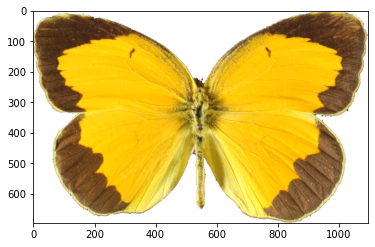

In [5]:
plt.imshow(img)

In [4]:
# this list holds all the image filename
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
   
data = {}
p = r"CHANGE TO A LOCATION TO SAVE FEATURE VECTORS"

# loop through each image in the dataset
for image in tqdm(images):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model)
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)


100%|████████████████████████████████████████████████████████████████████████████████| 830/830 [02:10<00:00,  6.37it/s]


NameError: name 'hdbscan' is not defined

In [8]:
# reduce the amount of dimensions in the feature vector
#pca = PCA(n_components=100, random_state=22)
#pca.fit(feat)
#x = pca.transform(feat)

x = umap.UMAP(n_neighbors=20,
                n_components=64,
                min_dist=0.0,
                metric='cosine',
                random_state=42).fit_transform(feat)

kmeans = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',
                          min_samples=1,
                          cluster_selection_epsilon=0.005,
                          cluster_selection_method='leaf', 
                          prediction_data=True).fit(x)

# cluster feature vectors
#kmeans = KMeans(n_clusters=90,n_jobs=-1, random_state=22)
#kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
        
   
# this is just incase you want to see which value for k might be the best 
#sse = []
#list_k = list(range(3, 100))

#for k in tqdm(list_k):
#    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
#    km.fit(x)
    
#    sse.append(km.inertia_)

# Plot sse against k
#plt.figure(figsize=(6, 6))
#plt.plot(list_k, sse)
#plt.xlabel(r'Number of clusters *k*')
#plt.ylabel('Sum of squared distance');

In [ ]:
# Print clusters visually
for i in tqdm(range(40,90)):
    view_cluster(i,groups)

In [10]:
# Save cluster information in CSV
clusters = []

for group in groups:
    for file in groups[group]:
        row = {'cluster': group, 'file' : file.split("\\")[-1], 'path': file}
        clusters.append(row)
        
df = pd.DataFrame(clusters)
df.to_csv('clusters.csv', index=False)